##### INF8460 ‚Äì Traitement automatique de la langue naturelle - Automne 2024

## TP3: G√©n√©ration automatique de mots-cl√©s (concepts) avec une architecture Transformer


## Identification de l'√©quipe:

### Groupe de laboratoire: 3

### Equipe num√©ro : 10

### Membres:

- Mohamed Ali Lajnef / 2404991 (45%, Travail sur la mise en place de l'architecture du mod√®le et sur les m√©triques et les questions d'interpr√©tations)
- Mathis Nguyen / 2409535 (45%, Travail sur la mise en place de l'architecture du mod√®le et sur la g√©n√©ration de textes)
- Einstein Franck Tiomo Epongo / 2093771 (10% R√©vision du code)


## 1. Objectif du TP

Dans ce TP, vous allez devoir impl√©menter en `PyTorch` un mod√®le suivant l'architecture Transformer cr√©√©e initialement dans l'article "[Attention Is All You Need](https://arxiv.org/pdf/1706.03762)".
<br>
Votre t√¢che sera d'impl√©menter l'architecture du Transformer et d'entra√Æner un mod√®le de type Transformer √† g√©n√©rer les concepts cl√©s d'une phrase. Votre mod√®le prendra donc en entr√©e une phrase quelconque en anglais et produira en sortie une s√©quence de mots correspondant aux concepts les plus importants de la phrase. Par exemple :
<br>

**Entr√©e** : "The dog jumped over the fence." <br>
**Sortie attendue** : ['dog' 'jump' 'fence']

Cette t√¢che a d'ailleurs plusieurs applications dans le monde r√©el allant de la g√©n√©ration de r√©sum√©s jusqu'√† la cr√©ation de bases de connaissances √† partir d'un texte.


#### Requis et ressources utiles

Il est fortement conseill√© de s'√™tre familiaris√© avec la librairie `PyTorch` avant d'entamer le TP. Par exemple, vous devriez savoir comment fonctionne un objet de type `nn.Module` et ce que la fonction `forward` de cet objet fait. Plusieurs tutoriels sont disponibles sur internet expliquant clairement le fonctionnement de la librairie. Voici certaines ressources qui peuvent √™tre utiles :
- [Build The Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [PyTorch Tutorial](https://github.com/yunjey/pytorch-tutorial?tab=readme-ov-file)


## 2. Jeu de donn√©es

Le jeu de donn√©es est compos√© de paires (phrase, concepts) o√π une phrase est mentionn√©e et la liste des concepts les plus importants de la phrase est indiqu√©e. Le jeu de donn√©es est divis√© en ensembles d'entra√Ænement, de validation et de test :
- Entra√Ænement : 4500 examples (train.csv)
- Validation : 500 examples (val.csv)
- Test : 500 examples (test.csv)

Pour une m√™me s√©quence de concepts, il y a 3 phrases pouvant √™tre associ√©es √† ces concepts. Par exemple, pour les concepts : ['cat' 'laptop' 'lie'], les phrases suivantes y sont associ√©es :
- A cat lying on a laptop
- A large cat lies down next to a laptop.
- There is a cat lying on top of the laptop.


## 3. LIBRAIRIES PERMISES
- Jupyter notebook
- PyTorch
- nltk
- transformers
- pandas
- matplotlib
- numpy
- Huggingface


Pour toute autre librairie, demandez √† votre charg√© de laboratoire

## 4. INFRASTRUCTURE

- Vous avez acc√®s aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)

## 5. √âTAPES DU TP

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as O
from torch.utils.data import DataLoader

# ML
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import math
import numpy as np

# System
from dataclasses import dataclass
import time
import re

# Huggingface
from tokenizers import CharBPETokenizer

Il vous faudra peut-√™tre t√©l√©charger ce module de `nltk`

In [ ]:
nltk.download('punkt')

### 1. Charger les donn√©es (2 points)

La premi√®re √©tape va √™tre de charger les donn√©es des fichiers d'entra√Ænement et d'√©valuation. Pour cela, nous allons utiliser la classe `Dataset` de `PyTorch`. Compl√©tez les fonctions de cette classe.

In [3]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, file_path: str = None, data: pd.DataFrame = None):

        if file_path is None and data is None:
            raise Exception('A file path or a dataframe must be passed to create a CustomDataset')

        if file_path != None:
            self.data = pd.read_csv(file_path)
        else:
            self.data = data.copy()

        # TODO : Enlever les donn√©es qui sont nulles et
        # assigner le r√©sultat dans la variable data
        self.data = self.data.dropna()
        # END TODO

    def __len__(self):
        # TODO : Retourne le nombre de donn√©es
        return len(self.data)
        # END TODO

    def __getitem__(self, idx: int):
        # TODO : Retourne l'√©l√©ment √† l'index "idx"
        return self.data.iloc[idx]
        # END TODO

    def get_column(self, column: str):
        # TODO : Retourne toutes les rang√©es de la colonne "column"
        return self.data[column]
        # END TODO

    def get_batch(self, idx: int, size):
        # TODO : Retourne toutes les rang√©es de l'index "idx" √† "idx" + "size"
        return self.data.iloc[idx:idx+size]
        # END TODO

    def transform(self, function):
        self.data = self.data.apply(function)

    def sample(self, nb_samples, random_state=42):
        return self.data.sample(n=nb_samples, random_state=random_state)

In [4]:
root = 'data/'

train_dataset = CustomDataset(root + 'train.csv')
test_dataset = CustomDataset(root + 'test.csv')
val_dataset = CustomDataset(root + 'val.csv')

INPUT_COLUMN = 'sentence'
OUTPUT_COLUMN = 'concepts'
MAX_LENGTH = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Vous pouvez changer sur quelle machine les calculs seront effectu√©s

In [5]:
print('Training set size : ', len(train_dataset))
print('Validation set size : ', len(val_dataset))
print('Testing set size : ', len(test_dataset))

Training set size :  4500
Validation set size :  500
Testing set size :  500


### 2. Statistiques (5 points)

Avant d'entamer la cr√©ation du mod√®le, il est important de se familiariser avec les donn√©es et d'√©valuer la taille des donn√©es avec lesquelles nous travaillons.

#### 2.1 Histogramme du nombre de caract√®res (2 points)

Compl√©tez la m√©thode `show_histogram_nb_characters` qui affiche un histogramme de la distribution du nombre de caract√®res des exemples de la colonne pass√©e en param√®tre. L'axe des abscisses devra repr√©senter le nombre de caract√®res et l'axe des ordonn√©es le nombre de documents. Utilisez des bacs (bins) de 20 pour l'histogramme. Affichez ensuite la distribution du nombre de caract√®res sur l'ensemble d'entra√Ænement pour la colonne 'sentence' et la colonne 'concepts'.

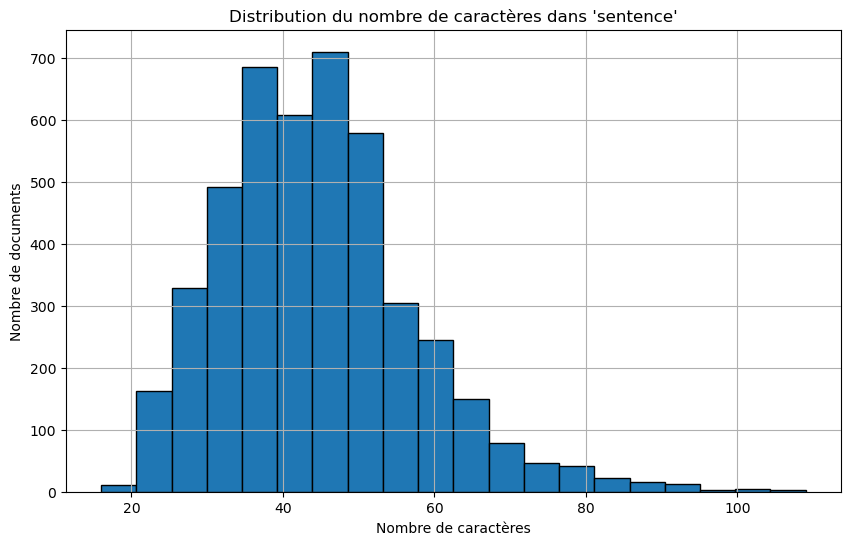

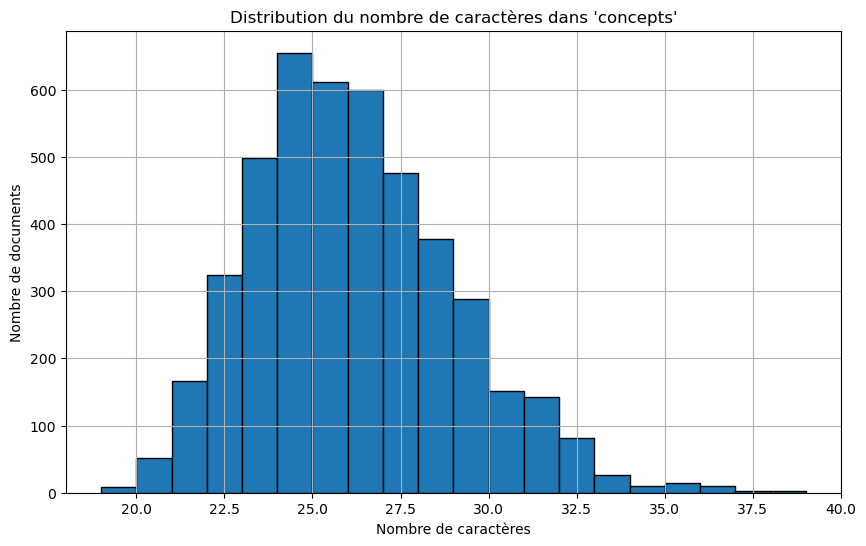

In [6]:
def show_histogram_nb_chararacters(dataset: CustomDataset, column: str):

    """
    Affiche la distribution de la colonne pass√© en param√®tre. L'histogramme doit contenir un titre et des titres sur les axes

    dataset: Dataset contenant plusieurs colonne dont la colonne dont les statistiques doivent √™tre affich√©es
    column: Colonne √† afficher

    """
    # TODO

    # On r√©cup√®re la colonne
    data = dataset.get_column(column)

    # On r√©cup√®re la longueur de chaque ligne
    char_lengths = data.apply(len) # les caract√®res "[" et "]" et "'" ainsi que les espaces sont inclus
    
    # Affichage de l'histogramme
    plt.figure(figsize=(10, 6))
    plt.hist(char_lengths, bins=20, edgecolor='black')
    plt.title(f"Distribution du nombre de caract√®res dans '{column}'")
    plt.xlabel("Nombre de caract√®res")
    plt.ylabel("Nombre de documents")
    plt.grid(True)
    plt.show()
    
    # END TODO


show_histogram_nb_chararacters(train_dataset, INPUT_COLUMN)
show_histogram_nb_chararacters(train_dataset, OUTPUT_COLUMN)

#### 2.2 Histogramme du nombre de mots par document (2 points)

De la m√™me mani√®re, compl√©tez la m√©thode `show_histogram_nb_words` qui affiche un histogramme de la distribution du nombre de mots des exemples de la colonne pass√©e en param√®tre. Utilisez des bacs (bins) de 20 pour l'histogramme. Affichez ensuite la distribution du nombre de mots sur l'ensemble d'entra√Ænement pour les colonnes "sentence" et "concepts". Dans le cas de la colonne 'concepts', assurez-vous que les '[', ']' et les apostrophes ne soient pas consid√©r√©es comme des mots.

Indice : Utilisez la m√©thode word_tokenize() de nltk.

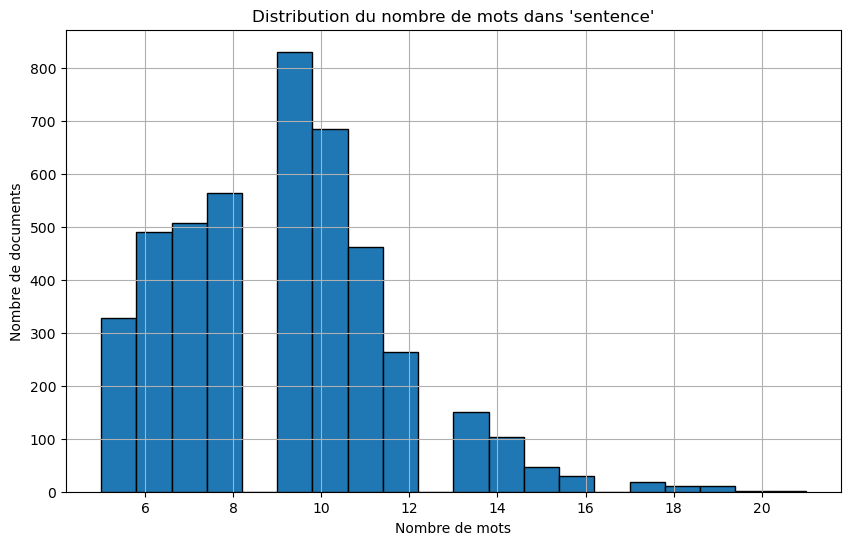

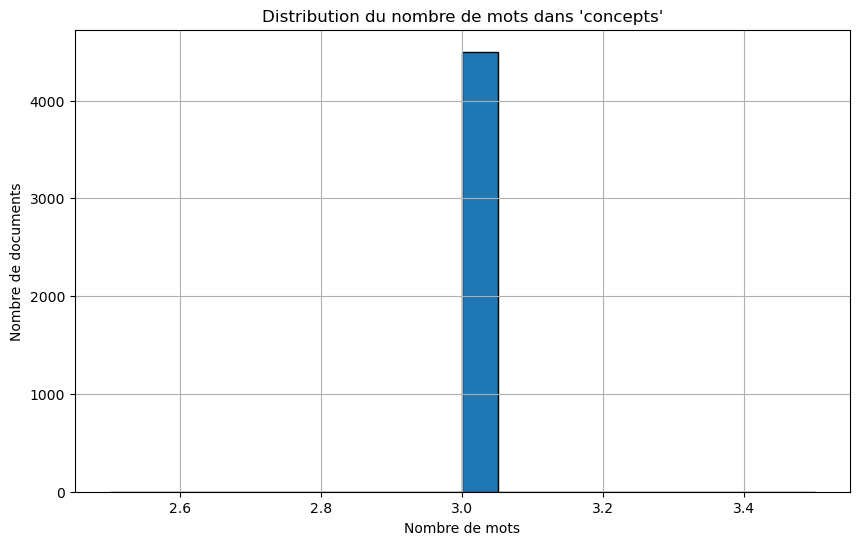

In [7]:
def show_histogram_nb_words(dataset: CustomDataset, column: str):

    """
    Affiche la distribution de la colonne pass√© en param√®tre du dataset. L'histogramme doit contenir un titre et des titres sur les axes

    dataset: Dataset contenant plusieurs colonne dont la colonne dont les statistiques doivent √™tre affich√©es
    column: Colonne √† afficher

    """
    # TODO

    # On r√©cup√®re la colonne
    data = dataset.get_column(column)

    # On compte le nombre de mots pour chaque ligne avec word_tokenize (apr√®s avoir enlev√© les caract√®res sp√©ciaux)
    word_counts = data.apply(lambda x: len(word_tokenize(x.replace('[', '').replace(']', '').replace("'", ''))))
    
    # Affichage de l'histogramme
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=20, edgecolor='black')
    plt.title(f"Distribution du nombre de mots dans '{column}'")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de documents")
    plt.grid(True)
    plt.show()
    
    # END TODO

show_histogram_nb_words(train_dataset, INPUT_COLUMN)
show_histogram_nb_words(train_dataset, OUTPUT_COLUMN)

#### 2.3 Commentez les graphiques (1 points)
1. Est-ce que les distributions suivent des distributions normales ?  
D'apr√®s les histogrammes, on voit que :  
- les distributions des mots ne suivent pas une loi normale  
- les distributions des caract√®res semblent tendre √† suivre une loi normale
2. Qu'observez-vous de sp√©cial sur la distribution du nombre de mots de la colonne "concepts" ? Pourquoi est-elle ainsi ?  
La distribution du nombre de mots de la colonne "concepts" est fixe car on cherche √† extraire 3 concepts pour chaque sentence. Cette colonne contient donc toujours 3 mots.

### 3. Segmentation (Tokenization) (5 points)

#### 3.1 Entra√Ænement du segmenteur (tokenizer) (3 points)
La fonction `word_tokenize()` de `nltk` est utile pour rapidement ressortir des statistiques, mais elle reste tr√®s g√©n√©rale et inefficace. Afin de r√©duire le plus possible la taille du vocabulaire, nous allons entra√Æner notre propre Tokenizer en nous basant sur l'algorithme BPE (Byte Pair Encoding). L'algorithme BPE est une m√©thode de compression de texte qui permet de cr√©er des tokenizers efficaces en regroupant les caract√®res les plus fr√©quents. Il commence par diviser le texte en caract√®res uniques, puis it√©rativement fusionne les paires de caract√®res les plus fr√©quentes en nouveaux symboles. Ce processus continue jusqu'√† atteindre un nombre pr√©d√©fini de jetons (tokens), permettant ainsi de g√©rer des vocabulaires de diff√©rentes tailles de mani√®re flexible et efficace. √Ä l'aide de BPE, nous allons transformer les mots en nombres pour pouvoir les passer au Transformer par la suite. Chaque jeton (token) sera associ√© √† un nombre correspondant √† l'indice du jeton dans le vocabulaire. Une s√©quence en entr√©e sera ainsi repr√©sent√©e comme une s√©quence de nombres.

De plus, des jetons sp√©ciaux seront ajout√©s au tokenizer pour sp√©cifier le d√©but d'une phrase (begin-of-sequence : `[BOS]`) et la fin d'une phrase (end-of-sequence : `[EOS]`). Un jeton de padding `[PAD]` sera utilis√© afin de s'assurer que toutes les phrases ont la m√™me taille. Finalement, un jeton `[UNK]` sera utilis√© pour les jetons inconnus.

Pour cr√©er ce vocabulaire √† l'aide de l'algorithme BPE, il faudra entra√Æner le tokenizer sur notre ensemble d'entra√Ænement pour qu'il puisse encoder efficacement les mots qui y sont pr√©sents. L'entra√Ænement est d√©j√† impl√©ment√© par la classe `ByteLevelBPYTokenizer` de la librairie `tokenizers`.

Vous n'avez qu'√† compl√©ter la fonction :
- `data_generator` qui retourne un g√©n√©rateur d'un lot (batch) de texte provenant de l'ensemble d'entra√Ænement. Pour chaque lot, les colonnes "sentence" et "concepts" sont concat√©n√©es pour former la cha√Æne finale qui sera envoy√©e au tokenizer. Les lots sont utiles lors de l'entra√Ænement pour acc√©l√©rer l'entra√Ænement en parall√©lisant le tout et en √©vitant de charger tout notre ensemble d'entra√Ænement en m√©moire directement.

In [8]:
VOCAB_SIZE = 8000
special_tokens = ['[PAD]', '[BOS]', '[EOS]', '[UNK]']
base_tokenizer = CharBPETokenizer(unk_token=special_tokens[-1])
tokenizer_batch_size = 64

def data_generator():
    """
    Generateur qui retourne un lot (batch) de texte provenant de l'ensemble d'entra√Ænement.
    Pour chaque √©l√©ment d'un lot, les colonnes "sentence" et "concepts" sont concat√©n√©e.
    """
    for i in range(0, len(train_dataset), tokenizer_batch_size):

        # TODO

        # On r√©cup√®re le batch
        batch = train_dataset.get_batch(i, tokenizer_batch_size)

        # On concat√®ne les colonnes
        text = batch['sentence'] + batch['concepts']
       
        # END TODO

        yield text


Vous devez maintenant compl√©ter la fonction :
- `train_tokenizer` qui prend en param√®tre un tokenizer pour entra√Æner ce dernier √† l'aide de la fonction [train_from_iterator](https://github.com/huggingface/tokenizers/blob/main/bindings/python/py_src/tokenizers/implementations/byte_level_bpe.py). Le g√©n√©rateur de donn√©es (data_generator) est envoy√© √† la fonction train_from_iterator tout comme la taille du vocabulaire, les jetons sp√©ciaux et la fr√©quence minimum d'une s√©quence pour la consid√©rer comme un jeton. Indiquez explicitement une fr√©quence minimum de 2.

In [9]:

from tokenizers import AddedToken, Tokenizer, decoders, pre_tokenizers, processors, trainers

def train_tokenizer(tokenizer: CharBPETokenizer):
    """
    Entra√Æne le tokenizer pass√© en param√®tre en appelant la fonction train_from_iterator
    et en sp√©cifiant le g√©n√©rateur de donn√©e (data_generator), la taille du vocabulaire,
    les jetons sp√©ciaux et une fr√©quence minimum de 2 (indiquez le explicitement)
    """
    # TODO

    # Appel de train_from_iterator avec les bons param√®tres 
    tokenizer.train_from_iterator(
        iterator=data_generator(),
        vocab_size=VOCAB_SIZE,
        special_tokens=special_tokens,
        min_frequency=2
    )
    
    # END TODO

train_tokenizer(base_tokenizer)

# On ajoute les jetons de d√©but, de fin de phrase et de jeton inconnu
bos_token_id = base_tokenizer.token_to_id("[BOS]")
eos_token_id = base_tokenizer.token_to_id("[EOS]")
unk_token_id = base_tokenizer.token_to_id("[UNK]")

# On applique un template au tokenizer pour qu'il ajoute
# les jetons au d√©but et √† la fin de chaque phrase
base_tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[BOS]:0 $A:0 [EOS]:0",
    special_tokens=[
        ("[BOS]", bos_token_id),
        ("[EOS]", eos_token_id),
    ],
)


Nous allons maintenant transformer notre tokenizer pour qu'il soit compatible avec l'API de la librairie Huggingface. Cela permettra entre autre de faciliter les appels de m√©thodes pour modifier facilement nos entr√©es. Par exemple, avec l'API de Huggingface, nous pouvons simplement appeler la m√©thode `tokenize` pour diviser une s√©quence en jetons (`Welcome` -> `[W, el, come]`). De la m√™me mani√®re, l'API nous permet d'appeler les m√©thodes `encode` et `decode` pour transformer une cha√Æne de caract√®res en s√©quences d'indices de jetons (`Welcome` -> `[36, 170, 664]`) et inversement.

In [ ]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(tokenizer_object=base_tokenizer._tokenizer, truncation=True)
tokenizer.add_special_tokens({
    'pad_token': "[PAD]",
    'bos_token': "[BOS]",
    'eos_token': "[EOS]",
    'unk_token': "[UNK]"
})

Testons maintenant notre tokenizer sur une phrase de test

In [11]:
test_input = 'Welcome ! The boat arrived at the station ! ü§ó '
print(test_input, '\n')
print(tokenizer.tokenize(test_input))

Welcome ! The boat arrived at the station ! ü§ó  

['W', 'el', 'come</w>', '!</w>', 'The</w>', 'boat</w>', 'arrived</w>', 'at</w>', 'the</w>', 'station</w>', '!</w>', '[UNK]']


Observons maintenant la m√™me phrase, mais une fois encod√©e en nombre. D√©codons-la ensuite √† partir de sa version encod√©e pour voir si nous retrouvons la phrase initiale.

- La m√©thode `encode` permet de transformer une s√©quence de mots en s√©quence de nombres correspondant aux indices des diff√©rents jetons de la phrase dans le vocabulaire
- La m√©thode `decode` permet de transformer une s√©quence d'indices de jetons en phrase lisible.

In [12]:
print('Texte initial : ', test_input)
print('=' * 100)
print('Texte encod√© : ', tokenizer.encode(test_input))
print('Texte d√©cod√© : ', tokenizer.decode(tokenizer.encode(test_input)))

Texte initial :  Welcome ! The boat arrived at the station ! ü§ó 
Texte encod√© :  [1, 36, 170, 664, 89, 277, 274, 2907, 126, 118, 254, 89, 3, 2]
Texte d√©cod√© :  [BOS]Welcome! The boat arrived at the station! [UNK][EOS]


#### 3.2 Que remarquez-vous dans la version segment√©e (tokenized) de la phrase de test ? Quelles sont les diff√©rences entre la phrase initiale et la phrase d√©cod√©e ? Pourquoi ? (2 points)

- Remarques dans la version segment√©e:
    - Certains jetons repr√©sentent des sous-unit√©s des mots. Comme 'W' et 'el' qui sont des sous-parties du mot 'Welcome'
    - Le symbole '<\/w>' pr√©sent √† la fin de certains jetons, symbolisant que ce jeton repr√©sente la fin d'un mot
    - Pr√©sence du jeton [UNK] indiquant un caract√®re que le tokenizer n'a pas √©t√© capable de reconna√Ætre

- Diff√©rences entre la phrase initiale et la phrase d√©cod√©e:
    - Ajout des jetons [BOS] et [EOS] au d√©but et √† la fin de la phrase initiale. Cet ajout sert √† marquer le d√©but et la fin d'une s√©quence dans le traitement par le mod√®le
    - Remplacement de l'emoji par le jeton [UNK]

La raison pour laquelle il y a ces diff√©rences entre la phrase initiale et la phrase d√©cod√©e est la suivante: </br>
- Le mod√®le ajoute les jetons [BOS], [EOS] et [UNK] pour respectivement d√©limiter le d√©but et la fin d'une s√©quence et pour repr√©senter les caract√®res qui n'apparaissent pas dans le dictionnaire.

### 4. Transformer (28 points)

Il est maintenant le temps de construire les couches du Transformer. Son architecture globale est pr√©sent√©e dans la figure suivante. :

![Transformer](images/transformer.png)

Les couches sont d√©finies pour vous et vous n'avez qu'√† compl√©ter, √† moins d'indication contraire, la fonction `forward` de chacune des classes qui prend un tenseur en entr√©e et effectue une transformation sur celui-ci pour g√©n√©rer une sortie. Cette transformation varie en fonction de chaque classe. Une description de ce que doit faire la classe est indiqu√©e √† chaque √©tape. Lorsque la fonction `forward` est complexe, une figure est fournie pour vous guider. Attention, ne changez pas le constructeur ou le nom de la classe !

#### 4.1 Positional Embedding
Le Transformer encode l'information de l'ordre des mots dans les plongements des mots. Des plongements de position sont calcul√©s et ils sont ajout√©s aux plongements de contexte. Dans ce cas-ci la classe `PositionalEmbedding` vous est donn√©e.

In [13]:
class PositionalEmbedding(nn.Module):
    """
    Cette classe a √©t√© prise de l'impl√©mentation originale du papier 'Attention Is All You Need'
    """

    def __init__(self, max_seq_length, embedding_dim):
        super(PositionalEmbedding, self).__init__()

        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim

        pe = torch.zeros(max_seq_length, self.embedding_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2).float() * -(math.log(10000.0) / self.embedding_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor):
        return x + self.pe[:, :x.size(1)]


#### 4.2 Attention (6 points)
Le m√©canisme d'attention est le coeur de l'architecture du Transformer. Il permet notamment la parall√©lisation de l'entra√Ænement tout en garantissant un lien direct entre tous les jetons. Vous devrez impl√©menter la fonction `scaled_dot_product_attention` qui effectue le calcul principal derri√®re le m√©canisme d'attention. Cette fonction prend en entr√©e les tenseurs `Q`, `K`, `V` et effectue le calcul suivant :
$$A = \texttt{softmax}\Big( \frac{Q K^T \odot M}{\texttt{head\_dim}} \Big) V$$
o√π $M$ est le masque d'attention qui doit √™tre appliqu√©. Plus de d√©tails sont indiqu√©s dans la description de la fonction √† propos du masque. Par rapport au tenseur de cl√©s, vous remarquerez dans la formule qu'une transpos√©e est appliqu√©e sur ce tenseur. √âtant donn√© qu'un tenseur poss√®de plus que 2 dimensions, il est important de sp√©cifier quelles dimensions seront transpos√©es dans le tenseur. Dans notre cas, il s'agit des dimensions correspondants aux jetons de la s√©quence et aux plongements des jetons

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert model_dim % num_heads == 0, "La dimension du mod√®le doit √™tre divisible par le nombre de t√™tes d'attention"

        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads

        self.wq = nn.Linear(model_dim, model_dim) # Query
        self.wk = nn.Linear(model_dim, model_dim) # Key
        self.wv = nn.Linear(model_dim, model_dim) # Value
        self.wo = nn.Linear(model_dim, model_dim) # Output

        self.mask_value = -1e9

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Calcule les plongements d'attention en utilisant la formule

        attn = softmax(Q * K^T @ mask / head_dim) * V

        Args :
            Q : plongements des queries
            Taille : [batch_size, num_heads, seq_length, head_dim]

            K : plongements des keys
            Taille : [batch_size, num_heads, seq_length, head_dim]

            V : plongement des values
            Taille : [batch_size, num_heads, seq_length, head_dim]

            mask : Masque d'attention qui doit √™tre appliqu√© avant le softmax pour que
            les jetons ne portent pas leur attention sur certains jetons. Le masque est
            notamment utilis√© dans le d√©codeur pour s'assurer que le transformer n'ait
            pas acc√®s aux futurs jetons lorsqu'il essaie de pr√©dire le prochain jeton.
            Il contient des valeurs 0 ou 1. Une valeur de 0 √† la position i,j indique
            que pour le jeton i, le jeton j doit √™tre masqu√©. Pour masquer la valeur,
            il suffit de mettre une valeur tr√®s petite (self.mask_value) √† l'indice i,j.
            La fonction masked_fill de PyTorch pourrait √™tre utile
            Taille : [1, seq_length, seq_length]

        Returns :
        R√©sultat du calcul d'attention de taille [batch_size, num_heads, seq_length, head_dim]
        """
        # TODO

        # Q * K^T / head_dim
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.head_dim**0.5
        
        # On applique le masque
        attn_scores_masked = attn_scores.masked_fill(mask == 0, self.mask_value)

        # Softmax
        attn_weights = F.softmax(attn_scores_masked, dim=-1)

        # On multiplie par V
        attn = torch.matmul(attn_weights, V)

        return attn    
        
        # END TODO

    def split_heads(self, x):
        """
        S√©pare une entr√©e sur plusieurs t√™tes d'attention

        Args :
            x : Tenseur d'entr√©e
            Taille : [batch_size, seq_length, model_dim]

        Returns :
        Tenseur s√©par√© sur plusieurs t√™tes d'attention
        Taille : [batch_size, num_heads, seq_length, head_dim]
        """
        return x.view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        """
        Combine une entr√©e √† travers les t√™tes d'attention

        Args :
            x : Tenseur d'entr√©e
            Taille : [batch_size, num_heads, seq_length, head_dim]

        Returns :
        Tenseur s√©par√© sur plusieurs t√™tes d'attention
        Taille : [batch_size, seq_length, model_dim]
        """
        return x.transpose(1, 2).contiguous().view(x.shape[0], x.shape[2], self.model_dim)

    def forward(self, queries, keys, values, mask=None):
        """
        Ex√©cute le m√©canisme d'attention √† travers plusieurs t√™tes
        d'attention

        Args :
            queries : plongements des queries
            Taille : [batch_size, seq_length, model_dim]

            keys : plongements des keys
            Taille : [batch_size, seq_length, model_dim]

            values : plongement des values
            Taille : [batch_size, seq_length, model_dim]

            mask : mask qui sera appliqu√©
            Taille : [1, seq_length, seq_length]

        Returns :
        Tenseur contenant les plongements finaux de chaque indice de
        la s√©quence
        Taille : [batch_size, seq_length, model_dim]
        """
        
        Q = self.split_heads(self.wq(queries))
        K = self.split_heads(self.wk(keys))
        V = self.split_heads(self.wv(values))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.wo(self.combine_heads(attn_output))

In [15]:
def test_attention():
    batch_size = 1
    seq_length = 4
    model_dim = 6
    num_heads = 2

    torch.random.manual_seed(42)
    attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)
    inputs = torch.randint(0, 10, (batch_size, seq_length, model_dim), dtype=torch.float32)
    mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1))
    print(attention.forward(inputs, inputs, inputs, mask=mask).detach())

test_attention()

tensor([[[-0.6789,  2.8487,  2.8666, -1.1983,  3.2915,  0.5359],
         [-0.3437,  3.1045,  3.0715, -1.1405,  3.2748,  0.3843],
         [-2.5825,  4.2728, -0.0114, -2.2663, -0.0922, -2.4731],
         [-2.5749,  4.2706, -0.0056, -2.2613, -0.0874, -2.4694]]])


Sortie attendue :
```
tensor([[[-0.6789,  2.8487,  2.8666, -1.1983,  3.2915,  0.5359],
         [-0.3437,  3.1045,  3.0715, -1.1405,  3.2748,  0.3843],
         [-2.5825,  4.2728, -0.0114, -2.2663, -0.0922, -2.4731],
         [-2.5749,  4.2706, -0.0056, -2.2613, -0.0874, -2.4694]]])
```

#### 4.3 Encodeur (6 points)
L'encodeur du Transformer encode la s√©quence d'entr√©e dans des vecteurs de contexte avant d'envoyer ces vecteurs de contexte au d√©codeur pour qu'ils puissent √™tre utilis√©s pour g√©n√©rer la s√©quence de sortie. Vous n'avez qu'√† compl√©ter les fonctions `forward` des classes `TransformerFeedForward`, `EncoderLayer` et `Encoder`. L'architecture d'une couche d'encodeur `EncoderLayer` est d√©crite dans la figure suivante :

![EncoderLayer](images/encoder_layer.png)

La classe `TransformerFeedForward` repr√©sente une couche simple de r√©seaux de neurones avec la fonction d'activation `ReLU` qui sera pr√©sente dans l'encodeur. Son architecture est d√©crite dans la figure suivante :

![TransformerFeedForward](images/transformer_feed_forward.png)

In [16]:
class TransformerFeedForward(nn.Module):

    def __init__(self, model_dim: int, ff_dim: int) -> None:
        super(TransformerFeedForward, self).__init__()
        self.model_dim = model_dim
        self.ff_dim = ff_dim

        self.ff1 = nn.Linear(model_dim, ff_dim)
        self.ff2 = nn.Linear(ff_dim, model_dim)

    def forward(self, x: torch.Tensor):
        """
        Applique les deux couches lin√©aires (ff) cons√©cutivement avec la fonction
        d'activation ReLU apr√®s chaque couche lin√©aire

        Args :
            x : Tenseur d'entr√©e de taille [batch_size, model_dim]

        Returns :
        Tenseur apr√®s √™tre pass√© √† travers les couches lin√©aires de taille
        [batch_size, model_dim]
        """
        # TODO

        # Couche ff1
        x = self.ff1(x)

        # Couche ReLU
        x = torch.relu(x)

        # Couche ff2
        x = self.ff2(x)

        # Couche ReLU
        x = torch.relu(x)

        return x 
        # END TODO

La classe `EncoderLayer` repr√©sente une seule couche qui applique le m√©canisme d'attention sur la sortie de la couche pr√©c√©dente. Dans le cas de la premi√®re couche d'encodeur, il s'agit simplement de la couche de plongements des jetons. Par la suite, le r√©sultat du m√©canisme d'attention est normalis√© et envoy√© √† une couche de r√©seau de neurones.

In [17]:
class EncoderLayer(nn.Module):

    def __init__(self, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(EncoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)
        self.feed_forward = TransformerFeedForward(model_dim=model_dim, ff_dim=ff_dim)
        self.attention_layer_norm = nn.LayerNorm(model_dim)
        self.ff_layer_norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, encoder_mask: torch.Tensor = None):
        """
        Applique la couche d'attention, de normalisation et de r√©seau de neurones
        sur l'entr√©e

        Args :
            x : Tenseur d'entr√©e de l'encodeur correspondant √† la s√©quence d'entr√©e
            Taille : [batch_size, seq_length, model_dim]

        Returns :
        Tenseur apr√®s avoir appliqu√©s les couches de taille [batch_size, seq_length,
        model_dim]
        """
        # TODO

        # Couche de Self-attention
        attention_out = self.self_attention(x, x, x, encoder_mask)

        # Couche Dropout
        attention_out = self.dropout(attention_out)
        
        # Couche Add & Norm
        x = self.attention_layer_norm(x + attention_out)
    
        # Couche Feed Forward
        ff_out = self.feed_forward(x)
        
        # Couche Dropout
        ff_out = self.dropout(ff_out) 

        # Couche Add & Norm
        x = self.ff_layer_norm(x + ff_out) 

        return x 
    
        # END TODO

La classe `Encoder` correspond √† une suite de plusieurs couches d'encodeurs. La fonction `forward` de cette classe doit appeler chacune des couches (`EncoderLayer`) une √† la suite de l'autre en passant √† la couche courante la sortie de la couche pr√©c√©dente. Le masque est partag√© entre toutes les couches `EncoderLayer`.

In [18]:
class Encoder(nn.Module):

    def __init__(self, num_layers: int, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList(
            [EncoderLayer(
                model_dim=model_dim,
                ff_dim=ff_dim,
                dropout_rate=dropout_rate,
                num_heads=num_heads,
            ) for _ in range(num_layers)]
        )

    def forward(self, x: torch.Tensor, encoder_mask: torch.LongTensor = None):
        """
        Applique toutes les couches d'encodeur cons√©cutivement

        Args :
            x : Tenseur d'entr√©e de l'encodeur correspondant √† la s√©quence d'entr√©e
            Taille : [batch_size, seq_length, model_dim]

            encoder_mask : Tenseur contenant le masque qui sera utilis√© par l'encodeur
            pour cacher certains jetons (notamment les jetons [PAD])
        Returns :
        Tenseur apr√®s avoir appliqu√©s les couches dans l'encodeur de taille
        [batch_size, seq_length, model_dim]
        """
        # TODO 

        # Appel de chaque couche :
        # *on passe la sortie courante √† la couche sup√©rieure
        # *on partage le masque entre les couches

        for layer in self.layers:
            x = layer(x, encoder_mask)
        return x
    
        # END TODO

#### 4.4 D√©codeur (8 points)
Le d√©codeur est la partie du Transformer qui g√©n√®re la s√©quence de sortie en prenant le contexte de la s√©quence d'entr√©e et les jetons qui ont √©t√© g√©n√©r√©s pr√©c√©demment. De la m√™me mani√®re que l'encodeur, la classe `DecoderLayer` repr√©sente une seule couche de d√©codeur. L'architecture du `DecoderLayer` est pr√©sent√©e dans la figure suivante :

![DecoderLayer](images/decoder_layer.png)

In [19]:
class DecoderLayer(nn.Module):

    def __init__(self, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)
        self.cross_attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)

        self.feed_forward = TransformerFeedForward(model_dim=model_dim, ff_dim=ff_dim)

        self.self_attention_layer_norm = nn.LayerNorm(model_dim)
        self.cross_attention_layer_norm = nn.LayerNorm(model_dim)
        self.ff_layer_norm = nn.LayerNorm(model_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self,
                x: torch.Tensor,
                encoder_out: torch.Tensor,
                encoder_mask: torch.LongTensor = None,
                decoder_mask: torch.LongTensor = None):
        """
        Applique les couches d'attention, de normalisation et de r√©seau de neurones
        sur l'entr√©e

        Args :
            x : Entr√©e du d√©codeur correspondant √† la s√©quence de sortie d√©cal√©e vers
            la droite
            Taille : [batch_size, seq_length, model_dim]

            encoder_output : Sortie de l'encodeur utilis√© pour la couche de cross-
            attention
            Taille : [batch_size, seq_length, model_dim]

            encoder_mask : Masque qui cache certains jetons dans la s√©quence d'entr√©e.
            Par exemple, les jetons [PAD] seront cach√©s puisqu'ils ne sont utilis√©s que
            pour aggrandir les s√©quences jusqu'√† la fen√™tre de contexte du Transformer
            Taille : [batch_size, seq_length, seq_length]

            decoder_mask : Masque qui cache certains jetons dans la s√©quence de sortie.
            Ce masque est notamment utilis√© dans le d√©codeur pour s'assurer que le
            transformer n'ait pas acc√®s aux futurs jetons lorsqu'il essaie de pr√©dire
            le prochain jeton.
            Taille : [batch_size, seq_length, seq_length]
        """
        # TODO

        # Couche de Self-attention 
        self_attention_out = self.self_attention(x, x, x, decoder_mask)
        # Couche Dropout
        self_attention_out = self.dropout(self_attention_out)
        # Couche Add & Normalize
        x = self.ff_layer_norm(x + self_attention_out)

        # Couche de Cross-attention 
        encoder_attention_out = self.cross_attention(x, encoder_out, encoder_out, encoder_mask) # On utilise la sortie de l'encodeur pour les cl√©s et valeurs pour l'attention crois√©e
        # Couche Dropout
        encoder_attention_out = self.dropout(encoder_attention_out)
        # Add & Norm
        x = self.ff_layer_norm(encoder_attention_out + x)
        
        # Couche Feed Forward
        ff_out = self.feed_forward(x)
        # Couche Dropout
        ff_out = self.dropout(ff_out)
        # Couche Add & Norm
        x = self.ff_layer_norm(ff_out + x)

        return x
        # END TODO

La classe `Decoder` repr√©sente toutes les couches du d√©codeur. La fonction `forward` de cette classe doit appeler chacune des couches (`DecoderLayer`) une √† la suite de l'autre en passant √† la couche courante la sortie de la couche pr√©c√©dente. Les attributs `encoder_out`, `encoder_mask` et `decoder_mask` sont partag√©s entre toutes les couches `DecoderLayer`.

In [20]:
class Decoder(nn.Module):

    def __init__(self, num_layers: int, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
            [DecoderLayer(
                model_dim=model_dim,
                ff_dim=ff_dim,
                dropout_rate=dropout_rate,
                num_heads=num_heads,
            ) for _ in range(num_layers)]
        )

    def forward(self, x: torch.Tensor, encoder_out: torch.Tensor, encoder_mask: torch.LongTensor = None, decoder_mask: torch.LongTensor = None):
        """
        Applique toutes les couches du d√©codeur cons√©cutivement

        Args :
            x : Tenseur d'entr√©e du d√©codeur correspondant √† la s√©quence de sortie
            Taille : [batch_size, seq_length, model_dim]

            encoder_out : Tenseur contenant la s√©quence d'entr√©e encod√©e par l'encodeur

            encoder_mask : Tenseur contenant le masque qui sera utilis√© par l'encodeur
            pour cacher certains jetons (notamment les jetons [PAD])

            decoder_mask : Tenseur contenant le masque qui sera utilis√© par le d√©codeur
            pour cacher certains jetons (notamment les jetons [PAD] et les jetons futurs)

        Returns :
        Tenseur apr√®s avoir appliqu√©s les couches dans l'encodeur de taille
        [batch_size, seq_length, model_dim]
        """
        # TODO

        # Appel de chaque couche :
        # *on passe la sortie courante √† la couche sup√©rieure
        # *on partage les masques et encoder_out entre les couches
        for layer in self.layers:
            x = layer(x, encoder_out, encoder_mask, decoder_mask)
        return x
    
        # END TODO

#### 4.5 Transformer (8 points)

L'architecture du Transformer est maintenant pr√™te √† √™tre assembl√©e. En utilisant les diff√©rentes couches que vous avez impl√©ment√©es, compl√©tez la fonction `forward` de la classe `Transformer` qui, √† partir de l'entr√©e de l'encodeur et du d√©codeur, g√©n√®re la sortie du d√©codeur. L'architecture, telle que pr√©sent√©e pr√©c√©demment, correspond √† la figure suivante :

![Transformer](images/transformer.png)

La fonction forward doit passer les entr√©es √† l'encodeur et au d√©codeur pour pouvoir g√©n√©rer une pr√©diction en fonction d'une entr√©e en appliquant les bons masques et encodages de position.

In [21]:
@dataclass
class TransformerConfig:

    model_dim: int = 512
    ff_dim: int = 2048

    nb_encoder: int = 6
    nb_decoder: int = 6

    num_heads: int = 8

    max_seq_length: int = MAX_LENGTH
    vocab_size: int = VOCAB_SIZE
    device: str = 'cpu'
    pad_token_id: int = 0


class Transformer(nn.Module):

    def __init__(self, config: TransformerConfig) -> None:
        super(Transformer, self).__init__()

        self.config = config
        self.enc_embeddings = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.model_dim
        )

        self.dec_embeddings = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.model_dim
        )

        self.positional_embeddings = PositionalEmbedding(
            max_seq_length=config.max_seq_length,
            embedding_dim=config.model_dim
        )

        self.encoder = Encoder(config.nb_encoder, config.model_dim, config.ff_dim, num_heads=config.num_heads)
        self.decoder = Decoder(config.nb_decoder, config.model_dim, config.ff_dim, num_heads=config.num_heads)

        self.linear_projection = nn.Linear(config.model_dim, config.vocab_size)
        self.device = config.device

    def generate_mask(self, src, tgt):
        """
        G√©n√®re les masques d'attentions pour l'encodeur et le d√©codeur du transformer en
        se basant sur le jeton de pad donn√© dans la configuration du transformer. Dans le
        cas du d√©codeur, un masque causal est √©galement calcul√© pour emp√™cher les jetons
        de porter leur attention sur les jetons futurs

        Args :
            src : S√©quence d'entr√©e

        """
        src_mask = (src != self.config.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != self.config.pad_token_id).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(self.device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, encoder_x: torch.Tensor, decoder_x: torch.Tensor):
        """
        G√©n√®re la sortie du d√©codeur √©tant donn√© une entr√©e pour l'encodeur et une entr√©e
        pour le d√©codeur

        Args :
            encoder_x : Tenseur d'entr√©e de l'encodeur
            Taille : [batch_size, seq_length]

            decoder_x : Tenseur d'entr√©e du d√©codeur
            Taille : [batch_size, seq_length]

        Returns :
        Sortie du d√©codeur correspondant au pr√©dictions du jeton le plus proche. Attention,
        n'appliquez pas softmax sur ces pr√©dictions. Ce tenseur devrait avoir une taille de
        [batch_size, seq_length, vocab_size]
        """

        # TODO
        
        # R√©cup√©ration des masques
        encoder_mask, decoder_mask = self.generate_mask(encoder_x, decoder_x)

        # Entr√©e pour l'encodeur (enc_embeddings + positional_embeddings)
        encoder_x = self.positional_embeddings(self.enc_embeddings(encoder_x))
        # Application et sortie de l'encodeur
        encoder_x = self.encoder(encoder_x, encoder_mask)

        # Entr√©e pour le d√©codeur (enc_embeddings + positional_embeddings)
        decoder_x = self.positional_embeddings(self.enc_embeddings(decoder_x))
        # Application et sortie du d√©codeur
        decoder_x = self.decoder(decoder_x, encoder_x, encoder_mask, decoder_mask)

        # Couche lin√©aire finale (projection dans l'espace du vocabulaire)
        decoder_y = self.linear_projection(decoder_x)
        
        return decoder_y
    
        # END TODO

### 5. Padding et coupure (5 points)

Il est important, lors de l'entra√Ænement que toutes les s√©quences aient la m√™me longueur de texte, car le Transformer prend toujours un nombre fixe de jetons. Cette taille correspond √† sa fen√™tre de contexte. Afin de s'assurer que toutes les s√©quences de texte dans un lot d'entra√Ænement soient de la m√™me longueur, nous allons couper les s√©quences trop longues et ajouter des jetons √† celles qui sont trop courtes. Le jeton qui sera ajout√© sera le jeton de "padding" du tokenizer (`[PAD]`).

Compl√©tez la fonction `tokenize` de la classe `DataCollator` qui s'occupe d'appeler le tokenizer avec les textes pass√©s en param√®tre en sp√©cifiant les param√®tres suivants :
- `padding`: `"max_length"` (Attention on veut la cha√Æne de charact√®re `"max_length"`, pas la variable)
- `truncation`: `True`
- `max_length`: La taille maximale pass√©e dans le constructeur
- `return_tensors`: `pt`
- `return_token_type_ids`: `False`
- `add_special_tokens`: `True`

Compl√©tez la fonction `__call__` qui s'occupe de prendre un lot de donn√©es (le lot/batch correspondant √† un sous-ensemble de l'ensemble d'entra√Ænement) et retourne les entr√©es de l'encodeur et du d√©codeur ainsi que la sortie du d√©codeur du Transformer. Vous devrez prendre le lot pass√© en param√®tre et transformer les colonnes `sentence` et `concepts` du lot en jetons. Les jetons de la colonne `sentence` seront envoy√©s √† l'encodeur et les jetons de la colonne `concepts` seront envoy√©s au d√©codeur.

In [22]:
from typing import Dict, List, Union


class DataCollator:
    def __init__(self, tokenizer: Tokenizer, max_length: int, device: str = 'cpu') -> None:
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

        self.pad_token_id = tokenizer.pad_token_id
        self.bos_token_id = tokenizer.bos_token_id
        self.eos_token_id = tokenizer.eos_token_id

    def tokenize(self, texts):
        """
        Transforme la s√©quence de textes en s√©quence d'indice de jetons

        Args :
            texts : Textes √† transformer

        Returns :
        Indices des jetons des textes
        """
        # TODO

        # Appel du tokenizer avec les bons param√®tres
        return self.tokenizer(texts, padding = "max_length", truncation = True, max_length = self.max_length, return_tensors = 'pt', return_token_type_ids = False, add_special_tokens = True)
    
        # END TODO

    def __call__(self, batch: List[Dict[str, Union[str, int]]]) -> Dict[str, torch.Tensor]:
        """
        Transforme une batch contenant les colonnes target et concepts en les envoyant au tokenizer
        et pr√©parant les jetons aux entr√©es et sorties de l'encodeur et du d√©codeur
        """
        # TODO

        # On tokenize les sentences
        sentences = [item['sentence'] for item in batch]
        encoder = self.tokenize(sentences)
        
         # On tokenize les concepts
        concepts = [item['concepts'] for item in batch]
        decoder = self.tokenize(concepts)      
    

        """
        Dans le d√©codeur, la s√©quence attendue est d√©cal√©e vers la droite d'un jeton √† l'entr√©e du d√©codeur.
        Par exemple, si on veut faire de la traduction, nous pourrions avoir la s√©quence suivante :

        La pomme est verte -> The apple is green

        Les valeurs du dictionnaire de retour serait donc :

        +-------------+--------+--------+--------+--------+--------+--------+
        |   Valeur    | Jeton1 | Jeton2 | Jeton3 | Jeton4 | Jeton5 | Jeton6 |
        +-------------+--------+--------+--------+--------+--------+--------+
        | encoder_in  | [BOS]  | la     | pomme  | est    | verte  | [EOS]  |
        | decoder_in  | [BOS]  | The    | apple  | is     | green  | [EOS]  |
        | decoder_out | The    | apple  | is     | green  | [EOS]  | [PAD]  |
        +-------------+--------+--------+--------+--------+--------+--------+

        Par exemple, pour le jeton 3, le transformer essaiera de pr√©dire le jeton "is" avec comme information
        tous les jetons de l'encodeur et tous les jetons pr√©c√©dents le "is" ([BOS] The apple).

        C'est d'ailleurs √† cause de ce d√©calage que nous enlevons le premier jetons dans 'decoder_out'. Aussi,
        le dernier jetons dans 'decoder_in' est enlev√©, car le Transformer ne devrait jamais voir le jeton
        de fin de phrase, car cela voudrait dire que la s√©quence est termin√©e. Il devrait seulement le pr√©dire.
        """

        # Pr√©paration des jetons pour les entr√©es et sorties de l'encodeur et du d√©codeur avec les d√©calages nec√©ssaires
        return {
            'encoder_in': encoder['input_ids'].to(self.device),
            'decoder_in': decoder['input_ids'][:, :-1].to(self.device),
            'decoder_out': decoder['input_ids'][:, 1:].to(self.device),
        }
        # END TODO
        


In [23]:
def test_data_collator():
    data_collator = DataCollator(tokenizer=tokenizer, max_length=16)
    sample_data = test_dataset[:2]
    result = data_collator(CustomDataset(data=sample_data))
    print('=' * 100)
    print()
    print('Encoder in detokenized : \n\n', '\n'.join(tokenizer.batch_decode(result['encoder_in'])))
    print()
    print('Decoder in detokenized : \n\n', '\n'.join(tokenizer.batch_decode(result['decoder_in'])))
    print()
    print('Decoder out detokenized : \n\n', '\n'.join(tokenizer.batch_decode(result['decoder_out'])))
    print()
    print('=' * 100)

test_data_collator()


Encoder in detokenized : 

 [BOS]two elephants standing next to each other in their pen [EOS][PAD][PAD][PAD][PAD]
[BOS]A big elephant that is standing there quietly in the pen. [EOS]

Decoder in detokenized : 

 [BOS]['elephant'' pen'' stand'] [EOS][PAD][PAD]
[BOS]['elephant'' pen'' stand'] [EOS][PAD][PAD]

Decoder out detokenized : 

 ['elephant'' pen'' stand'] [EOS][PAD][PAD][PAD]
['elephant'' pen'' stand'] [EOS][PAD][PAD][PAD]



Sortie attendue :
```
====================================================================================================

Encoder in detokenized :

 [BOS]two elephants standing next to each other in their pen [EOS][PAD][PAD][PAD][PAD]
[BOS]A big elephant that is standing there quietly in the pen. [EOS]

Decoder in detokenized :

 [BOS]['elephant'' pen'' stand'] [EOS][PAD][PAD]
[BOS]['elephant'' pen'' stand'] [EOS][PAD][PAD]

Decoder out detokenized :

 ['elephant'' pen'' stand'] [EOS][PAD][PAD][PAD]
['elephant'' pen'' stand'] [EOS][PAD][PAD][PAD]

====================================================================================================
```

### 6. Cr√©ation de lots (Batching)

Nous allons utiliser la classe `DataLoader` de PyTorch pour charger les donn√©es en "batchs". La classe `DataCollator` sera pass√©e en param√®tre lors du chargement des donn√©es pour automatiquement transformer le texte en jetons.

In [24]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 128

collator = DataCollator(tokenizer=tokenizer, max_length=MAX_LENGTH, device=DEVICE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, collate_fn=collator)

### 7. Entra√Ænement (26 points)

#### 7.1 Boucle d'entra√Ænement (20 points)

Pour pouvoir g√©n√©rer des pr√©dictions qui ont du sens, il faut entra√Æner le mod√®le √† effectuer ces pr√©dictions √† partir des donn√©es d'entra√Ænement. Pour cela, la classe `Trainer` sera utilis√©e. Elle permettra au mod√®le, √† partir de donn√©es d'entra√Ænement, d'apprendre la bonne combinaison de param√®tres qui effectue les meilleures pr√©dictions. Nous validerons ensuite les pr√©dictions avec l'ensemble de test. L'ensemble de validation sera utilis√© durant l'entra√Ænement pour s'assurer que le mod√®le apprend bien.

Compl√©ter les fonctions `train_epoch` et `validation_epoch` de la classe `Trainer` pour permettre au transformer pass√© en param√®tre du constructeur d'√™tre entra√Æn√© avec les donn√©es d'entra√Ænement.

La fonction `train_epoch` doit :
- Parcourir toutes les lots (batchs) d'entra√Ænement et pour chaque lot :
  - Entra√Æner le mod√®le pour ce lot en √©valuant la fonction de perte et mettant √† jour les param√®tres en fonction des gradients
- Calculer la perte d'entra√Ænement moyenne
- Mettre la perte d'entra√Ænement dans un objet de la classe `History`

La fonction `validation_epoch` doit :
- Parcourir tous les lots de validation et pour chaque lot :
  - √âvaluer le mod√®le sur ce lot en √©valuant la fonction de perte
- Calculer la perte de validation moyenne
- Mettre la perte de validation dans un objet de la classe `History`

In [25]:
from tqdm import tqdm

class History:

    def __init__(self):
        self.t_loss = []
        self.v_loss = []
        self.time_to_train = -1

class Trainer:

    def __init__(self,
                 transformer: Transformer,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 num_epochs: int,
                 loss_function = None,
                 device='cpu',
                 saving_path='model') -> None:
        """
        Args :
            transformer: Mod√®le qui sera entra√Æn√©

            train_loader: Objet contenant les donn√©es d'entra√Ænement en batch

            val_loader: Objet contenant les donn√©es de validation en batch

            num_epochs: Nombre d'√©tape d'entra√Ænement (une √©tape √©quivaut √†
            parcourir toutes les donn√©es une fois)

            loss_function: Fonction de perte utilis√©e lors de l'entra√Ænement. Si
            le param√®tre est laiss√© √† `None`, la fonction d'entropie crois√©e sera
            utilis√©e en ignorant les jetons de pad (retrouv√©s avec la config du mod√®le)

            device: Machine sur laquelle le mod√®le sera entra√Æn√©
        """

        self.model = transformer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_epochs = num_epochs
        self.device = device
        self.saving_path = saving_path

        self.optimizer = O.Adam(self.model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

        if loss_function is None:
            self.loss_function = nn.CrossEntropyLoss(ignore_index=transformer.config.pad_token_id).to(self.device)
        else:
            self.loss_function = loss_function

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor):
        """
        Trouve la valeur de la fonction de perte (self.loss_function)
        √©tant donn√© les probabilit√©s (logits) pr√©dits et les vraies
        valeurs (labels)

        Args :
            logits:     Probabilit√©s pr√©dites par le mod√®le sur le prochain
                        jeton pour chacun des jetons de la s√©quence
                        Tenseur de taille : [batch_size, seq_length, vocab_size]

            labels:     Jetons qui devraient √™tre pr√©dis comme les prochains
                        jetons pour chaque jeton de la s√©quence
                        Tenseur de taille : [batch_size, seq_length]
        """

        _, _, vocab_size = logits.shape
        return self.loss_function(logits.contiguous().view(-1, vocab_size), labels.contiguous().view(-1))

    def train_epoch(self, history):
        """
        Entra√Æne le mod√®le sur tous les lots du `self.train_loader` et calcule
        la perte d'entra√Ænement moyen en l'ajoutant √† l'objet history pass√© en
        param√®tre

        Args :
            history :   Objet contenant les statistiques d'entra√Ænement d'un mod√®le
        """

        # TODO
        self.model.train()
        total_loss = 0
        for batch in self.train_loader :

            # R√©cup√©rer les entr√©es √† partir des donn√©es d'entrainement
            encoder_inputs = batch['encoder_in'].to(self.device)
            decoder_inputs = batch['decoder_in'].to(self.device)
            decoder_targets = batch['decoder_out'].to(self.device)
            
            # Appeler le mod√®le
            outputs = self.model(encoder_inputs, decoder_inputs)

            # Evaluer la perte et mettre √† jour les param√®tres
            loss = self.compute_loss(outputs, decoder_targets)
            self.optimizer.zero_grad()  
            loss.backward()         
            self.optimizer.step()
            total_loss+=loss.item()
            
        # Stocker la perte d'entrainement moyenne dans history
        avg_loss = total_loss / len(self.train_loader)
        history.t_loss.append(avg_loss) 
                
        # END TODO

    def validation_epoch(self, history):
        """
        √âvalue le mod√®le sur tous les lots du `self.val_loader` et calcule
        la perte de validation moyen en l'ajoutant √† l'objet history pass√© en
        param√®tre

        Args :
            history :   Objet contenant les statistiques d'entra√Ænement d'un mod√®le
        """

        # TODO
        self.model.eval()
        with torch.no_grad() :
            total_loss = 0
            for batch in self.val_loader :

                # R√©cup√©rer les entr√©es √† partir des donn√©es de validation
                encoder_inputs = batch['encoder_in'].to(self.device)
                decoder_inputs = batch['decoder_in'].to(self.device)
                decoder_targets = batch['decoder_out'].to(self.device)
                
                # Appeler le mod√®le                
                outputs = self.model(encoder_inputs, decoder_inputs)

                # Evaluer la perte
                loss = self.compute_loss(outputs , decoder_targets)     
                total_loss+=loss.item()

            # Stocker la perte de validation moyenne dans history
            avg_loss = total_loss / len(self.val_loader)
            history.v_loss.append(avg_loss)
        # END TODO


    def train(self) -> History:
        """
        Entra√Æne `self.model` en utilisant les donn√©es de `self.train_loader`

        Returns :
        Historique contenant les perte d'entra√Ænement et de validation moyennes
        pour chaque √©tape (epoch) d'entra√Ænement
        """
        history = History()
        start = time.time()
        self.model.to(self.device)


        for epoch in tqdm(range(self.num_epochs)):

            self.train_epoch(history)
            self.validation_epoch(history)

            print(f'Epoch {epoch} / {self.num_epochs} : train_loss = {history.t_loss[-1]}, val_loss = {history.v_loss[-1]}')

            if epoch > 0 and epoch % 10 == 0:
                self.save(f'{self.saving_path}_{epoch}.pt')

        end = time.time()
        history.time_to_train = end - start
        self.save(f'{self.saving_path}_{self.num_epochs}.pt')
        return history

    def save(self, path: str):
        """
        Saves the model in the specified path
        """
        torch.save(self.model.state_dict(), path)

    @staticmethod
    def load(config: TransformerConfig, path: str):
        """
        Loads the model from the specified path
        """
        model = Transformer(config)
        model.load_state_dict(torch.load(path))
        return model

#### 7.2 Nombre de param√®tres (2 points)
Compl√©tez maintenant la fonction `count_parameters` permettant de calculer le nombre de param√®tres du mod√®le

In [26]:
def count_parameters(model):
    """
    Calcule le nombre de param√®tres que l'on peut entra√Æner dans un mod√®le

    Args :
        model : Mod√®le dont on veut savoir le nombre de param√®tres

    Returns :
    Nombre de param√®tres
    """
    # TODO
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params
    # END TODO

config = TransformerConfig()
config.device = DEVICE
model = Transformer(config)

print('Nombre de param√®tres : ', count_parameters(model))

Nombre de param√®tres :  56434496


#### 7.3 Entra√Ænement (4 points)
Entra√Ænez maintenant le mod√®le pour 30 √©poques

In [27]:
# TODO
trainer_model = Trainer(model, train_loader, val_loader, 30, device=DEVICE)
history = History() # Mettez le r√©sultat de l'entra√Ænement dans cette variable
history = trainer_model.train()
# END TODO

  3%|‚ñé         | 1/30 [00:05<02:40,  5.52s/it]

Epoch 0 / 30 : train_loss = 3.8775587214363947, val_loss = 2.9560807943344116


  7%|‚ñã         | 2/30 [00:09<02:08,  4.60s/it]

Epoch 1 / 30 : train_loss = 2.3290361563364663, val_loss = 2.7501895427703857


 10%|‚ñà         | 3/30 [00:13<01:56,  4.30s/it]

Epoch 2 / 30 : train_loss = 1.9988097614712186, val_loss = 2.65766704082489


 13%|‚ñà‚ñé        | 4/30 [00:17<01:48,  4.19s/it]

Epoch 3 / 30 : train_loss = 1.7895747621854146, val_loss = 2.486793875694275


 17%|‚ñà‚ñã        | 5/30 [00:21<01:44,  4.19s/it]

Epoch 4 / 30 : train_loss = 1.6127677493625217, val_loss = 2.450264573097229


 20%|‚ñà‚ñà        | 6/30 [00:25<01:39,  4.13s/it]

Epoch 5 / 30 : train_loss = 1.5312090052498712, val_loss = 2.4696695804595947


 23%|‚ñà‚ñà‚ñé       | 7/30 [00:29<01:34,  4.10s/it]

Epoch 6 / 30 : train_loss = 1.4652502470546298, val_loss = 2.4221116304397583


 27%|‚ñà‚ñà‚ñã       | 8/30 [00:33<01:29,  4.08s/it]

Epoch 7 / 30 : train_loss = 1.3702128794458177, val_loss = 2.3398739099502563


 30%|‚ñà‚ñà‚ñà       | 9/30 [00:37<01:26,  4.12s/it]

Epoch 8 / 30 : train_loss = 1.2450806962119207, val_loss = 2.246920943260193


 33%|‚ñà‚ñà‚ñà‚ñé      | 10/30 [00:41<01:21,  4.09s/it]

Epoch 9 / 30 : train_loss = 1.1226013501485188, val_loss = 2.1929794549942017
Epoch 10 / 30 : train_loss = 1.0110819902684953, val_loss = 2.1459734439849854


 40%|‚ñà‚ñà‚ñà‚ñà      | 12/30 [00:50<01:14,  4.13s/it]

Epoch 11 / 30 : train_loss = 0.9086583488517337, val_loss = 2.124184250831604


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 13/30 [00:54<01:10,  4.12s/it]

Epoch 12 / 30 : train_loss = 0.8163717488447825, val_loss = 2.1022177934646606


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 14/30 [00:59<01:09,  4.34s/it]

Epoch 13 / 30 : train_loss = 0.7338266604476504, val_loss = 2.0822646617889404


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 15/30 [01:03<01:03,  4.26s/it]

Epoch 14 / 30 : train_loss = 0.6591060558954874, val_loss = 2.055498719215393


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 16/30 [01:07<01:00,  4.30s/it]

Epoch 15 / 30 : train_loss = 0.5912762681643168, val_loss = 2.056119203567505


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 17/30 [01:11<00:55,  4.25s/it]

Epoch 16 / 30 : train_loss = 0.5267046292622884, val_loss = 2.0455166697502136


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 18/30 [01:16<00:51,  4.30s/it]

Epoch 17 / 30 : train_loss = 0.5332867867416806, val_loss = 2.0159897804260254


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 19/30 [01:20<00:47,  4.30s/it]

Epoch 18 / 30 : train_loss = 0.4561872101492352, val_loss = 2.0272796750068665


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 20/30 [01:24<00:43,  4.31s/it]

Epoch 19 / 30 : train_loss = 0.39704036712646484, val_loss = 2.0189214944839478
Epoch 20 / 30 : train_loss = 0.35420982870790696, val_loss = 2.022769272327423


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 22/30 [01:33<00:35,  4.39s/it]

Epoch 21 / 30 : train_loss = 0.3176621695359548, val_loss = 2.0224061608314514


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 23/30 [01:38<00:30,  4.36s/it]

Epoch 22 / 30 : train_loss = 0.28184569047556984, val_loss = 2.032068371772766


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 24/30 [01:42<00:26,  4.38s/it]

Epoch 23 / 30 : train_loss = 0.24999099059237373, val_loss = 2.0448644757270813


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 25/30 [01:47<00:22,  4.42s/it]

Epoch 24 / 30 : train_loss = 0.22069824238618216, val_loss = 2.0483914613723755


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 26/30 [01:51<00:17,  4.44s/it]

Epoch 25 / 30 : train_loss = 0.19204864568180507, val_loss = 2.0463821291923523


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 27/30 [01:55<00:13,  4.39s/it]

Epoch 26 / 30 : train_loss = 0.16877692689498267, val_loss = 2.0579628944396973


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 28/30 [02:00<00:08,  4.34s/it]

Epoch 27 / 30 : train_loss = 0.1446266836590237, val_loss = 2.065000534057617


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 29/30 [02:04<00:04,  4.44s/it]

Epoch 28 / 30 : train_loss = 0.1256653227739864, val_loss = 2.0807682275772095


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30/30 [02:09<00:00,  4.31s/it]

Epoch 29 / 30 : train_loss = 0.10885180077619022, val_loss = 2.0996776819229126


### 8. Historique d'entra√Ænement (5 points)

#### 8.1 Graphique (2 points)
Compl√©tez la fonction `show_history` qui affiche l'historique d'entra√Ænement (perte d'entra√Ænement et perte de validation par √©poque, utilisez des pas de 5 √©poques) du mod√®le dans un graphe.

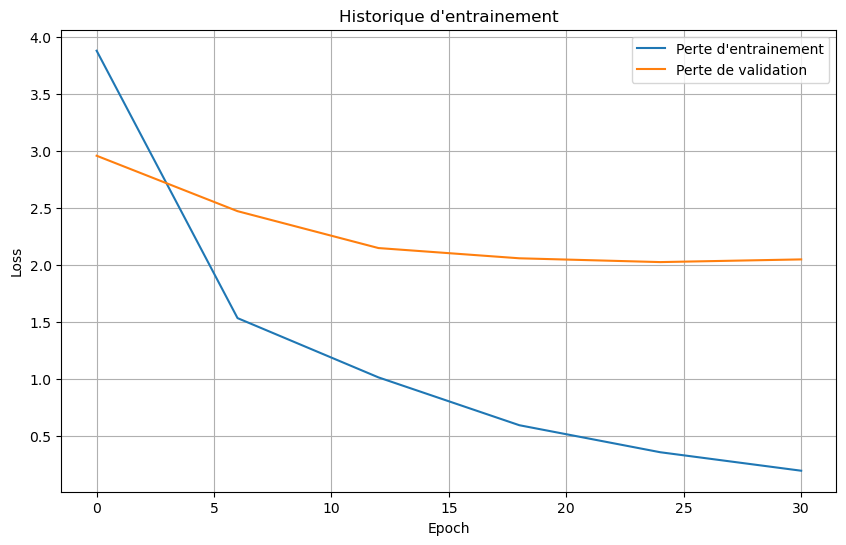

In [28]:
def show_history(history: History):
    """
    Affiche l'historique d'entra√Ænement du mod√®le dans un graphique

    Args :
        history : Objet contenant les pertes d'entra√Ænement et de
        validation de chaque √©tape d'entra√Ænement
    """
    # TODO

    plt.figure(figsize=(10,6))
    epochs = np.linspace(0, 30, 6) 
    plt.plot(epochs, history.t_loss[::5], label = 'Perte d\'entrainement')
    plt.plot(epochs, history.v_loss[::5], label = 'Perte de validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Historique d\'entrainement')
    plt.grid()
    plt.show()

    # END TODO

show_history(history)

#### 8.2 Est-ce que le mod√®le semble √™tre en sur-apprentissage ? Pourquoi ? Que feriez-vous pour r√©soudre ce probl√®me ? (2 points)

D'apr√®s l'analyse des courbes de perte de validation et d'entra√Ænement, il semble que le mod√®le commence √† montrer des signes de sur-apprentissage apr√®s un certain nombre d'epochs. Cela est indiqu√© par la perte de validation qui atteint un plateau puis augmente l√©g√®rement apr√®s l'epoch 25, tandis que la perte d'entra√Ænement continue de diminuer. Il y a alors un √©cart tr√®s important entre la perte de validation et la perte d'entra√Ænrment. Pour contrer le sur-apprentissage, on pourrait envisager d'utiliser du 'early stopping', qui arr√™te l'entra√Ænement lorsque la perte de validation cesse de diminuer. On pourrait aussi utiliser de la r√©gularisation (L1 ou L2) ce qui pourrait √©galement aider √† r√©duire le sur-apprentissage en rendant le mod√®le moins sensible au bruit des donn√©es d'entra√Ænement.

#### 8.3 Lors de l'entra√Ænement, un mod√®le a √©t√© sauvegard√© √† chaque 10 √©poques. En vous basant sur le graphique de la fonction de perte durant l'entra√Ænement, choisissez la sauvegarde du mod√®le qui n'est pas en sur-apprentissage et chargez le pour l'√©valuation √† l'aide de la fonction `load` de la classe `Trainer`. Chargez √©galement le dernier mod√®le sauvegard√© pour comparer les r√©sultats. (1 point)

Nous d√©noterons le mod√®le arr√™t√© avant le sur-apprentissage comme √©tant : `stopped_model`

Nous d√©noterons le dernier mod√®le sauvegard√© comme √©tant : `last_model`

In [ ]:
# TODO

# Mettez vos deux mod√®les entra√Æn√©s dans ces variables pour la suite
stopped_model = Trainer.load(config=config, path='model_20.pt').to(DEVICE)
last_model = Trainer.load(config=config, path='model_30.pt').to(DEVICE)

# END TODO

### 9. √âvaluation (20 points)

#### 9.1 G√©n√©ration (10 points)
Maintenant que le mod√®le est entra√Æn√©, nous pouvons tester ses g√©n√©rations. Compl√©tez la fonction `generate` qui g√©n√®re, pour un lot de donn√©es, les pr√©dictions d'un mod√®le sur les concepts cl√©s de la phrase donn√©e en param√®tre.

In [30]:
def generate(model: Transformer, encoder_in: torch.tensor, bos_token_id: int, eos_token_id: int, max_length=MAX_LENGTH):
    """
    G√©n√®re les pr√©dictions d'un mod√®le pour des phrases donn√©es en param√®tre. Pour cela, vous devez
    initialiser un tenseur X contenant les jetons de d√©but de phrase (bos_token_id). Ensuite, ce
    tenseur sera pass√© comme entr√©e au d√©codeur avec `encoder_in` comme entr√©e √† l'encodeur. Le mod√®le
    g√©n√®rera un jeton en sortie qui sera le jeton le plus probable √©tant donn√© le jeton de d√©but de
    phrase et la s√©quence pass√©e dans l'encodeur. Ce jeton devra √™tre concat√©n√© au tenseur initial X
    pour former une s√©quence de deux jetons. Cette nouvelle s√©quence est ensuite r√©envoy√©e au d√©codeur.
    Un jeton en sortie sera g√©n√©r√© correspondant au jeton le plus probable √©tant donn√© la s√©quence de
    deux jetons et l'entr√©e de l'encodeur. Le nouveau jeton est concat√©n√© au tenseur X et l'op√©ration
    est r√©p√©t√©e jusqu'√† ce que le d√©codeur g√©n√®re le jeton de fin de phrase.

    Args :
        model : Mod√®le effectuant les pr√©dictions

        inputs : Tenseur contenant les phrases d'entr√©es sous forme d'indices de jetons

        bos_token_id : Jeton d'entr√©e du tokenizer utilis√© pour initialiser le tenseur de g√©n√©ration

        eos_token_id : Jeton de fin du tokenizer utilis√© pour d√©tecter la fin d'une s√©quence

        max_length : Nombre maximal de jetons qui doivent √™tre g√©n√©r√©s par le mod√®le

    Returns :
    G√©n√©ration du mod√®le de chacune des phrases en entr√©e
    """
    # TODO
    model.eval()

    # Taille du batch courant
    current_batch_size = encoder_in.size(0)

    # Initialisation du tenseur X contenant les jetons de d√©but de phrase (chaque ligne correspondra √† la pr√©diction de "concepts" pour chaque phrase de "sentence" du batch)
    x = torch.full((current_batch_size, 1), bos_token_id, dtype=torch.long, device=DEVICE)

    # Initialisation d'un indicateur pour les pr√©dictions termin√©es
    finished_sequences = torch.zeros(current_batch_size, dtype=torch.bool, device=DEVICE)

    for _ in range(max_length):
        # Appel du mod√®le pour g√©n√©rer les pr√©dictions pour chaque phrase de "sentence" du batch
        output = model(encoder_in, x)
        
        # R√©cup√©ration des pr√©dictions associ√©es √† la derni√®re s√©quence de jetons (compl√®te) de decoder_in
        output = output[:, -1, :]

        # Extraction des nouveaux jetons pr√©dits (jetons du vocabulaire dont la probabilit√© est la plus haute)
        next_tokens = output.argmax(dim=-1, keepdim=True)

        # Concat√©nation des jetons pour former la nouvelle s√©quence pour l'appel suivant
        next_tokens[finished_sequences] = eos_token_id # Si un token de fin de phrase a d√©j√† √©t√© g√©n√©r√©, alors on fixe le token suivant comme un token de fin de phrase car on arr√™te de g√©n√©rer pour cette s√©quence
        x = torch.cat([x, next_tokens], dim=1)

        # Mise √† jour des s√©quences termin√©es (si une pr√©diction a g√©n√©r√© un token de fin de phrase, alors la pr√©diction pour "concepts" est termin√©e pour cette "sentence")
        finished_sequences = finished_sequences | (next_tokens.squeeze(1) == eos_token_id)
        # On peut s'arr√™ter si toutes les s√©quences sont termin√©es
        if finished_sequences.all():
            break

    return x
    # END TODO

In [31]:
def get_predictions(model, tokenizer):

    bos_token_id = tokenizer("")['input_ids'][0]
    eos_token_id = tokenizer("")['input_ids'][1]

    sentences = []
    predictions = []
    ground_truth = []
    for test_data in test_loader:

        inputs = test_data['encoder_in']
        result = generate(model, inputs, bos_token_id, eos_token_id)

        sentences.extend(tokenizer.batch_decode(test_data['encoder_in'], skip_special_tokens=True))
        ground_truth.extend(tokenizer.batch_decode(test_data['decoder_out'], skip_special_tokens=True))
        predictions.extend(tokenizer.batch_decode(result, skip_special_tokens=True))

    return sentences, ground_truth, predictions

sentences_stopped, ground_truth_stopped, predictions_stopped = get_predictions(stopped_model, tokenizer)
sentences_last, ground_truth_last, predictions_last = get_predictions(last_model, tokenizer)

In [32]:
predictions_stopped = pd.DataFrame({'sentences': sentences_stopped, 'ground_truth': ground_truth_stopped, 'predictions': predictions_stopped})
predictions_last = pd.DataFrame({'sentences': sentences_last, 'ground_truth': ground_truth_last, 'predictions': predictions_last})

In [33]:
predictions_stopped.to_csv('predictions_stopped.csv', index=False)
predictions_last.to_csv('predictions_last.csv', index=False)

#### 9.2 √âvaluation naive de la g√©n√©ration (1 point)
Nous allons d'abord mesurer l'efficacit√© de notre mod√®le pour extraire les concepts √† l'aide d'une m√©trique de correspondance exacte (exact match). Pour cela, nous allons mesurer le nombre de g√©n√©rations (`predictions`) qui sont identiques √† celles qui sont attendues dans l'ensemble de r√©f√©rence (`ground truth`) et diviser le tout par le nombre totaux d'√©l√©ments dans l'ensemble de r√©f√©rence. Ainsi, la m√©trique EM (exact match) √©quivaut √† :

$$\text{EM} = \frac{\text{Nombre d'√©l√©ments identiques entre l'ensemble g√©n√©r√© et l'ensemble de r√©f√©rence}}{\text{Nombre d'√©l√©ments dans l'ensemble de r√©f√©rence}}$$

In [39]:
def compute_em_score(data):
    """
    √âvalue la m√©trique EM du mod√®le en utilisant la m√©trique BLEU
    Args :
        - data : DataFrame contenant les colonnes predictions et ground_truth

    Returns :
    La m√©trique EM du mod√®le en pourcentage
    """
    # TODO
    
    EM = (data['predictions'] == data['ground_truth']).mean()
    return EM 
        
    # END TODO

print(f"La m√©trique EM du mod√®le arr√™t√© selon la fonction de perte est {compute_em_score(predictions_stopped):.2f}")
print(f"La m√©trique EM du dernier mod√®le est {compute_em_score(predictions_last):.2f}")

La m√©trique EM du mod√®le arr√™t√© selon la fonction de perte est 0.06
La m√©trique EM du dernier mod√®le est 0.11


#### 9.3 Quels probl√®mes voyez-vous avec cette mani√®re de calculer la performance du mod√®le ? (1 point)

La m√©trique Exact Match (EM) pr√©sente une limitation significative en raison de sa nature binaire. Elle ne consid√®re une r√©ponse comme correcte que si la pr√©diction correspond exactement √† la valeur r√©elle. Cela n√©glige les situations o√π le mod√®le identifie correctement certains concepts sans les capturer tous, ou les cas o√π tous les concepts sont identifi√©s, mais pas dans l'ordre sp√©cifi√© par la valeur r√©elle. Aussi, si un concept est assez proche s√©mantiquement du concept attendu, mais n'est pas exactement celui-ci, la m√©trique consid√®rera simplement la pr√©diction comme incorrecte.

#### 9.4 M√©trique BLEU (4 points)
Pour pallier √† ce probl√®me, la m√©trique BLEU sera utilis√©e puisqu'elle est bas√©e sur le nombre de n-gramme qui sont pr√©sents dans les pr√©dictions et les s√©quences voulues. La formule est donn√©e ci-dessous :
$$BLEU = BP * exp \Big( \sum_{n=1}^{N} w_n \log p_n \Big)$$

Consid√©rant que $r$ est la phrase de r√©f√©rence (voulue) et $c$ la phrase g√©n√©r√©e (candidate), $p_n$ est la pr√©cision modifi√©e pour le n-gramme (correspondant au ratio de la fr√©quence maximum du n-gramme dans la phrase de r√©f√©rence par la fr√©quence du n-gramme): 
$$p_n = \frac{\sum_{\text{n-gramme} \in c} \min\Big( \max_{r} \text{Count$_r$(n-gramme)}, \text{Count$_c$(n-gramme)} \Big)}{\sum_{\text{n-gramme} \in c} \text{Count$_c$(n-gramme)}}$$

Notez que le $\max_{r}$ est pr√©sent ici car BLEU accepte plusieurs phrases de r√©f√©rence pour une m√™me phrase g√©n√©r√©e. Cependant, dans notre cas, il y a seulement une seule phrase de r√©f√©rence.

Posons ensuite $|r|$ comme le nombre de mots dans la phrase cible et $|c|$ comme le nombre de mots dans la phrase pr√©dite. Si $c>r$, alors BP vaut 1. Sinon $$BP = exp(1 - \frac{|r|}{|c|})$$

Les valeurs des poids $w_n$ est ce qui donne les diff√©rentes variations de la m√©trique BLEU. Dans notre cas, la m√©trique BLEU-1 sera utilis√©e. La valeur maximale du score BLEU est 1 et la valeur minimale est 0.

Vous pouvez utiliser la fonction `sentence_bleu` de `nltk` pour calculer votre score BLEU. N'oubliez pas d'enlever les apostrophes et les crochets des g√©n√©rations avant votre calcul.

In [35]:
from nltk.translate.bleu_score import sentence_bleu
import warnings
def compute_bleu(predictions):
    """
    √âvalue la pr√©cision du mod√®le en utilisant la m√©trique BLEU
    Args :
        - data : DataFrame contenant les colonnes predictions et ground_truth

    Returns :
        La moyenne du score BLEU
    """
    weights = (1, 0, 0, 0) # Use Bleu-1
    # TODO
     
    bleu_scores = []
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for _, row in predictions.iterrows():
            
            reference = row['ground_truth'].replace('[', '').replace(']', '').replace("'", "").split()
            candidate = row['predictions'].replace('[', '').replace(']', '').replace("'", "").split()

            score = sentence_bleu([reference], candidate, weights=weights)
            bleu_scores.append(score)
    
    mean_bleu = sum(bleu_scores) / len(bleu_scores)
    return mean_bleu
    # END TODO

print(f"Le score BLEU du mod√®le arr√™t√© selon la fonction de perte est {compute_bleu(predictions_stopped):.2f}")
print(f"Le score BLEU du dernier mod√®le est {compute_bleu(predictions_last):.2f}.")

Le score BLEU du mod√®le arr√™t√© selon la fonction de perte est 0.52
Le score BLEU du dernier mod√®le est 0.61.


#### 9.5 Quel est l'avantage d'utiliser la m√©trique BLEU par rapport √† la m√©trique EM bas√©e sur la comparaison de cha√Æne de caract√®res ? (2 points)

Avec cette m√©trique, on prend cette fois-ci en compte le fait de retrouver un certain nombre de concepts parmi tous les concepts attendus. Autrement dit, la m√©trique n'est plus binaire : si le mod√®le ne trouve par exemple qu'un seul concept parmi les trois attendus, le score ne sera pas nul comme c'est le cas pour la m√©trique EM. Aussi, si on distingue tous les concepts mais pas dans l'ordre indiqu√© dans la r√©f√©rence, le score BLEU sera maximal contrairement √† EM o√π il aurait √©t√© nul. Cela donne alors une id√©e plus pr√©cise de la qualit√© de notre mod√®le de pr√©diction.

#### 9.6 Que remarquez-vous par rapport aux performances du mod√®le arr√™t√© avant le sur-apprentissage selon la fonction de perte versus celles du dernier mod√®le ? Quelles sont les raisons qui peuvent expliquer cela ? (2 points)

En analysant les m√©triques, on peut avoir tendance √† dire que le dernier mod√®le performe mieux que le mod√®le arr√™t√©. Ce r√©sultat n'est pas incoh√©rent car m√™me si le dernier mod√®le est en sur-apprentissage, il ne faut pas oublier que le jeu utilis√© pour le calcul des m√©triques est un jeu de test, qui est donc diff√©rent du jeu de validation. Ainsi, il est possible que le mod√®le soit plus performant pour ce jeu de test, malgr√© son sur-apprentissage.

### 10. Exploration (4 points)

#### 10.1 Explorez les g√©n√©rations actuelles de votre mod√®le et ressortez 2 probl√®mes que le mod√®le a lors de la g√©n√©ration qui font diminuer son score BLEU. (2 points)

Notre mod√®le pr√©sente deux probl√®mes majeurs :

- Il g√©n√®re parfois plusieurs occurrences du m√™me concept pour une seule phrase.
- Il produit des concepts incluant des mots qui ne figurent pas dans la phrase d'origine. Bien que cela puisse sembler indiquer une compr√©hension nuanc√©e des phrases par notre mod√®le, nos observations montrent que les valeurs de r√©f√©rence se limitent uniquement aux mots pr√©sents dans les phrases. Il serait donc pr√©f√©rable que notre mod√®le adopte la m√™me approche.

#### 10.2 Am√©lioration des m√©triques (2 points)
L'exemple ci-dessous montre 2 g√©n√©rations de 2 mod√®les pour la phrase "A dog is eating a flower". Bien que la g√©n√©ration du mod√®le 2 soit beaucoup plus proche s√©mantiquement de la r√©f√©rence que celle du mod√®le 1, la m√©trique BLEU retourne 0.0 dans les deux cas. En effet, puisque la m√©trique ne compare que les n-grammes, la pr√©diction du mod√®le 2 est quand m√™me de 0, car aucun des mots dans la pr√©diction ne sont pr√©sents dans les concepts voulus.

In [40]:
ground_truth = "['dog' 'eat' 'flower']"

prediction_1 = "['car' 'hit' 'person']"
preds = pd.DataFrame({'predictions': [prediction_1], 'ground_truth': [ground_truth]})

print(f"Concepts voulus {ground_truth}")
print(f"Pr√©diction du mod√®le 1 : {prediction_1}")
print(f"BLEU : {compute_bleu(preds):.2f}")

prediction_2 = "['animal' 'eating' 'plant']"
preds = pd.DataFrame({'predictions': [prediction_2], 'ground_truth': [ground_truth]})

print(f"Pr√©diction du mod√®le 2 : {prediction_2}")
print(f"BLEU : {compute_bleu(preds):.2f}")

Concepts voulus ['dog' 'eat' 'flower']
Pr√©diction du mod√®le 1 : ['car' 'hit' 'person']
BLEU : 0.00
Pr√©diction du mod√®le 2 : ['animal' 'eating' 'plant']
BLEU : 0.00


Proposez (sans l'impl√©menter) une meilleure m√©trique pour √©valuer les mod√®les face √† cette t√¢che d'extraction qui donnerait un score plus √©lev√© √† la pr√©diction du mod√®le 2. 

Pour √©valuer plus pr√©cis√©ment la capacit√© d'un mod√®le √† comprendre le contenu s√©mantique des phrases dans des t√¢ches d'extraction de concepts, une approche bas√©e sur la *similarit√© s√©mantique* serait plus appropri√©e que les n-grammes stricts utilis√©s par BLEU. Une m√©trique possible pourrait √™tre une moyenne des *similarit√©s cosinus* entre les vecteurs de mots des pr√©dictions et ceux de la r√©f√©rence. Voici une description de cette approche:

- Transformer chacun des mots en un plongement de mots. On peut utiliser pour cela des mod√®les pr√©-entra√Æn√©s tel que Glove, World2Vec ou FastText.
- Construire une matrice (matrice de similarit√©) o√π chaque √©l√©ment i,j correspond √† la similarit√© cosinus entre le i-√®me mot pr√©dit et le j-√®me concept de r√©f√©rence.
- Utilisez l'algorithme hongrois (ou algorithme de Kuhn-Munkres) pour trouver l'appariement qui maximise la somme globale des similarit√©s entre les mots pr√©dits et les concepts de r√©f√©rence. Notez que ceci est d√ªe au fait que l'on cherche √† associer un concept pr√©dit √† un seul concept de r√©f√©rence.
- Apr√®s avoir obtenu l'appariement optimal, calculez la moyenne des valeurs de similarit√© correspondantes. Ce score moyen repr√©sente la qualit√© s√©mantique de la pr√©diction par rapport aux concepts voulus.
- Normalisez le score final pour qu'il soit compris entre 0 et 1, o√π 1 indique une correspondance parfaite et 0 l'absence de correspondance.

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les num√©ros de questions avec vos r√©ponses dans le pdf gr√¢ce √† l'outil que fournit Gradescope.


## √âvaluation 
Votre TP sera √©valu√© selon les crit√®res suivants :
1. Ex√©cution correcte du code et obtention des sorties attendues
2. R√©ponses correctes aux questions d'analyse
3. Qualit√© du code (noms significatifs, structure, performance, gestion d‚Äôexception, etc.)
4. Commentaires clairs et informatifs